**CNN avec bande modulation cepstrale sur corpus glides pixels mélangés**

Ce model complètementaire sert à comparer équitablement le CNN face au SVM après les suggestions de Mr Audibert


Importation des bibliothèques

In [45]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from keras.layers import ZeroPadding2D, Conv2D
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import glob
import csv
from sklearn.metrics import confusion_matrix

Importation du corpus train et test pour la classe malade et sain a été réalisation en deux groupes pour chacun , malade et non malade. 
Le choix de la taille des images a été fait empiriquement, au départ nous voulions faire 1*28 car l'image d'entrée est une bande, neanmoins les performances du modèle baissées drastiquement. De plus cette importation en bande nous laissait peu de marge de manoeuvre pour le choix des kernels , alors, nous avons opté pour un format carré.

In [46]:
list_malade = glob.glob('malade_mfcc_glides/test/*')
list_ok = glob.glob('sain_mfcc_glides/test/*')
img_rows=28
img_cols=28
x_test = []  
y_test = []

dico = {'malade': 0, 'non_malade': 1}
#test
for path in list_malade:
    x=cv2.imread(path,0).astype(np.uint8)
    x=cv2.resize(x,(img_rows,img_cols))
    y = dico['malade']
    x_test.append(x)
    y_test.append(y)

for path in list_ok:
    x=cv2.imread(path,0).astype(np.uint8)
    x=cv2.resize(x,(img_rows,img_cols))
    y = dico['non_malade']
    x_test.append(x)
    y_test.append(y)


#train

list_malade_train = glob.glob('malade_mfcc_glides/train/*')
list_ok_train = glob.glob('sain_mfcc_glides/train/*')

x_train = []
y_train = []


for path in list_malade_train:
    x = cv2.imread(path, 0).astype(np.uint8)
    x = cv2.resize(x, (img_rows, img_cols))
    y = dico['malade']
    x_train.append(x)
    y_train.append(y)

for path in list_ok_train:
    x = cv2.imread(path, 0).astype(np.uint8)
    x = cv2.resize(x, (img_rows, img_cols))
    y = dico['non_malade']
    x_train.append(x)
    y_train.append(y)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
# Mélanger les pixels à l'intérieur de chaque vecteur dans x_train
for i in range(len(x_train)):
    np.random.shuffle(x_train[i])

# Mélanger les pixels à l'intérieur de chaque vecteur dans x_test
for i in range(len(x_test)):
    np.random.shuffle(x_test[i])
x_train = x_train.reshape(-1, img_rows, img_cols, 1)
x_test = x_test.reshape(-1, img_rows, img_cols, 1)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Définition de la fonction sheduler permettant de faire évoluer le taux d'apprentissage en fonction du nombre d'epoch

In [47]:
def lr_schedule(epoch):
    lr = 1e-4
    if epoch > 30:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.5
    return lr

Lors de l'initialisation du modèle nous avons opté pour une couche de normalisation sous la plupart des couches denses, cela a permis d'améliorer les performances du programme. Le choix de la fonction d'activation sigmoid s'est fait car c'est une tâche de classification en 2 classes. L'activation relu a été utilisé car c'est celle qui a le mieux fonctionner, la fonction tanh fonctionnait aussi plutôt bien mais nous avions des pertes de performances.

In [48]:
model = Sequential()
model.add(Conv2D(512, kernel_size=(2, 2), activation='relu', input_shape=(img_rows, img_cols, 1), padding='same'))
model.add(BatchNormalization())
value_top = 0
value_bottom = 0
value_left = 0
value_right = 0
model.add(ZeroPadding2D(padding=((value_top, value_bottom), (value_left, value_right))))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (2, 2), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 512)       2560      
                                                                 
 batch_normalization_30 (Ba  (None, 28, 28, 512)       2048      
 tchNormalization)                                               
                                                                 
 zero_padding2d_6 (ZeroPadd  (None, 28, 28, 512)       0         
 ing2D)                                                          
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 14, 14, 512)       0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 256)       524544    
                                                      

Lancement de l'entrainement et de l'évaluation. Nous avons choisi 25 epochs pour que ça concorde avec notre nombre de donnée. Le choix de l'epoch s'est fait à l'aide de la visualitation du graphique du nombre d'epoch en fonction du taux d'apprentissage. De plus nous avons la fonction early stopping qui nous permet d'éviter le surapprentissage, lorsque le modèle cesse de s"améliorer nous l'arrêtons.

In [54]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=3, patience=35)
lr_scheduler = LearningRateScheduler(lr_schedule)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=25, epochs=70, verbose=1, validation_split=0.2, callbacks=[es, lr_scheduler])
model.save('model.h5')
score=model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/70
19/19 [==============================] - 2s 52ms/step - loss: 0.1374 - accuracy: 0.9366 - val_loss: 2.3034 - val_accuracy: 0.4874 - lr: 1.0000e-04
Epoch 2/70
19/19 [==============================] - 1s 43ms/step - loss: 0.1153 - accuracy: 0.9683 - val_loss: 2.6833 - val_accuracy: 0.3950 - lr: 1.0000e-04
Epoch 3/70
19/19 [==============================] - 1s 43ms/step - loss: 0.1053 - accuracy: 0.9598 - val_loss: 2.7844 - val_accuracy: 0.3529 - lr: 1.0000e-04
Epoch 4/70
19/19 [==============================] - 1s 43ms/step - loss: 0.1176 - accuracy: 0.9514 - val_loss: 3.4892 - val_accuracy: 0.2773 - lr: 1.0000e-04
Epoch 5/70
19/19 [==============================] - 1s 45ms/step - loss: 0.0853 - accuracy: 0.9704 - val_loss: 2.6289 - val_accuracy: 0.3697 - lr: 1.0000e-04
Epoch 6/70
19/19 [==============================] - 1s 45ms/step - loss: 0.0765 - accuracy: 0.9704 - val_loss: 2.0997 - val_accuracy: 0.5042 - lr: 1.0000e-04
Epoch 7/70
19/19 [==============================] - 

C:\Users\Natou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test loss: 0.31919145584106445
Test accuracy: 0.8522727489471436


Lancement de la prédiction sur le corpus test. Nous pouvons voir une matrice de confusion avec une diagonale bien lisible. Il a néanmoins plus de mal à classer les locuteurs de la classe non malade en raison de leur grand diversité. Les malades ont souvent le même pattern , un débit plus lent et une intensité similaire, c'est moins le cas dans le groupe non malade.

6/6 [==============================] - 0s 18ms/step


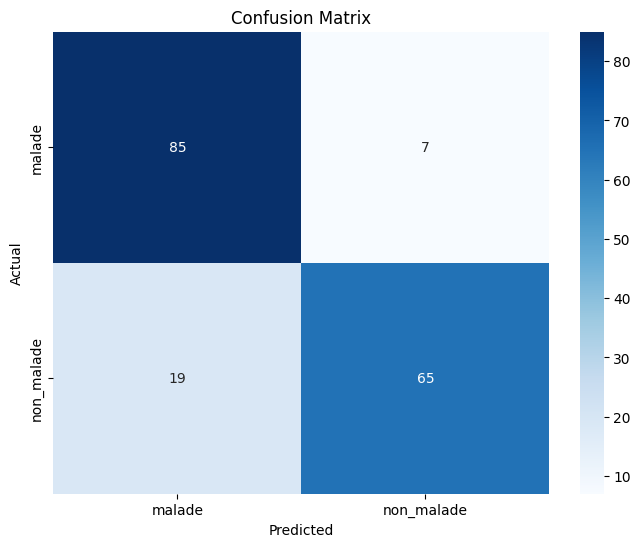

In [55]:
y_pred_probs = model.predict(x_test)
#print(y_pred_probs)
y_pred = np.argmax(y_pred_probs, axis=1)
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['malade', 'non_malade'], yticklabels=['malade', 'non_malade'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Enregistrement des mauvaises prédictions dans un fichier CSV qui nous permet de voir qui est mal cassé et avec quel stimuli

In [57]:

misclassified_data = []

for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        actual_class = 'malade' if y_test[i] == 0 else 'non_malade'
        predicted_class = 'malade' if y_pred[i] == 0 else 'non_malade'
        image_name = os.path.basename(list_malade[i]) if i < len(list_malade) else os.path.basename(list_ok[i - len(list_malade)])
        
        misclassified_data.append([image_name, actual_class, predicted_class])

csv_file_path = 'mal_class_glides_bandes.csv'
header = ['Image Name', 'Actual Class', 'Predicted Class']

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(misclassified_data)

print(f"c'est save :D {csv_file_path}")
import pandas as pd
res=pd.DataFrame(misclassified_data)
print(res)

c'est save :D mal_class_glides_bandes.csv
                                                    0           1           2
0   SCA_F_AB30_2020_11_26_ModuleTransitions_aj1.tx...      malade  non_malade
1   SCA_F_AB30_2020_11_26_ModuleTransitions_uj4.tx...      malade  non_malade
2   SCA_F_AB30_2020_11_26_ModuleTransitions_wi4.tx...      malade  non_malade
3   SCA_F_AB31_2020_11_26_ModuleTransitions_aj3.tx...      malade  non_malade
4   SCA_H_AB25_2020_11_13_ModuleTransitions_aj2.tx...      malade  non_malade
5   SCA_H_AB25_2020_11_13_ModuleTransitions_aj3.tx...      malade  non_malade
6   SCA_H_AB37_2020_02_11_ModuleTransitions_wi3.tx...      malade  non_malade
7   SNC_F_AB1_2019_11_07_ModuleTransitions_aj4.txt...  non_malade      malade
8   SNC_F_AB1_2019_11_07_ModuleTransitions_wi1.txt...  non_malade      malade
9   SNC_F_AB1_2019_11_07_ModuleTransitions_wi2.txt...  non_malade      malade
10  SNC_F_EC16_2019_12_13_ModuleTransitions_uj1.tx...  non_malade      malade
11  SNC_F_SC3_2019_11_

Ce qui est intéressant ici c'est qu'ici il classe mal les personnes peu atteinte, elles ont un score très bas dans les métadonnées ( Le locuteur AB30 et AB25 )
Pour les locuteurs non attentin il est interessant de voir que ce sont souvent les mêmes stimus qui sont mal classés , uj et wi. Ces deux stimulis sont compliqués à prononcer et son sujet à une grande variation, cela pourrait brouiller le modèle et se voir dans les images.

Ci-dessous vous trouverez les métadonnées des personnaes avec le nom du locuteur et son taux de sévérité.

In [ ]:
#faire un coode qui affiche les métadonnées

Un graphique montrant la répartition des mal cassés.

In [ ]:
#faire le code